In [1]:
import cv2

import numpy as np
from robust_line_based_estimator.line_matching.line_matcher import LineMatcher
from robust_line_based_estimator.visualization import plot_images, plot_lines, plot_color_line_matches
import pygcransac
import pyprogressivex
import seaborn as sns

In [2]:
img0_file = '/home/remi/Documents/datasets/RANSAC-Tutorial-Data/val/st_peters_square/images/99951716_5027797309.jpg'  # 'img/terrace0.JPG'
img0 = cv2.imread(img0_file, 0)
img1_file = '/home/remi/Documents/datasets/RANSAC-Tutorial-Data/val/st_peters_square/images/99909629_4872049450.jpg'  # 'img/terrace1.JPG'
img1 = cv2.imread(img1_file, 0)

# LSD+SuperGlueEndpoints matcher
lsd_sg_matcher = LineMatcher(line_detector='lsd', line_matcher='superglue_endpoints')

Loaded SuperPoint model
Loaded SuperGlue model ("outdoor" weights)


## Line detection and description

/home/remi/env_daniel/lib/python3.6/site-packages/torch/nn/functional.py:4004: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


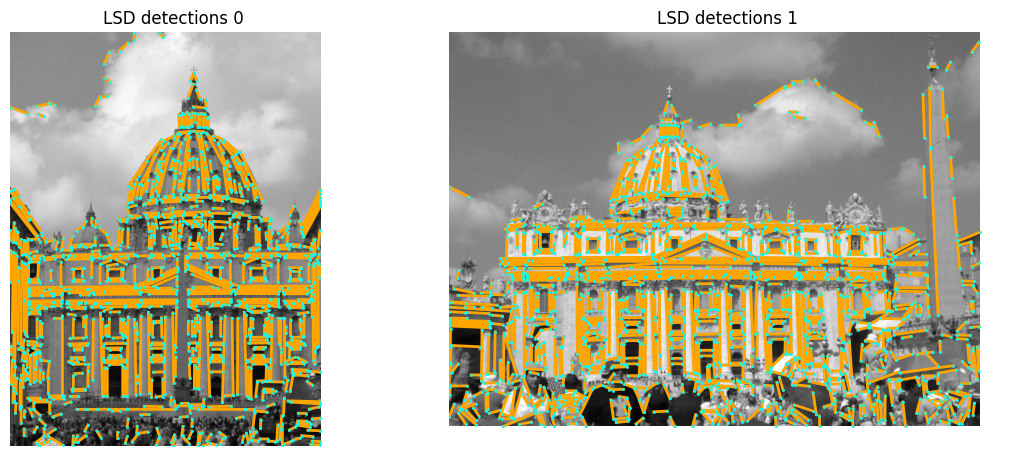

In [3]:
## LSD detections
lsd_sg_features0 = lsd_sg_matcher.detect_and_describe_lines(img0)
lsd_sg_features1 = lsd_sg_matcher.detect_and_describe_lines(img1)

# Display the detections
plot_images([img0, img1], ['LSD detections 0', 'LSD detections 1'])
plot_lines([lsd_sg_features0["line_segments"][:, :, [1, 0]], lsd_sg_features1["line_segments"][:, :, [1, 0]]])

## Line matching

/home/remi/Programmes/robust-line-based-estimator/robust_line_based_estimator/line_matching/superglue_endpoints.py:549: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dtype=torch.float, device=self.device),
/home/remi/Programmes/robust-line-based-estimator/robust_line_based_estimator/line_matching/superglue_endpoints.py:552: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dtype=torch.float, device=self.device),


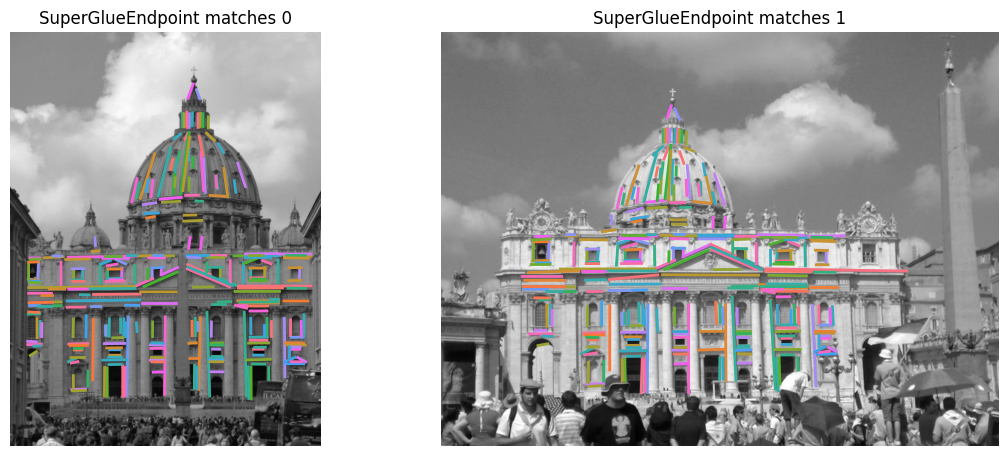

In [4]:
## SuperGlueEndpoint matching
_, m_lines0_sg, m_lines1_sg = lsd_sg_matcher.match_lines(img0, img1, lsd_sg_features0, lsd_sg_features1)

# Plot the matches
plot_images([img0, img1], ['SuperGlueEndpoint matches 0', 'SuperGlueEndpoint matches 1'])
plot_color_line_matches([m_lines0_sg[:, :, [1, 0]], m_lines1_sg[:, :, [1, 0]]])

In [5]:
def find_homography_points(lines0, lines1, img1_size, img2_size, threshold = 3.0, confidence = 0.5, minimum_point_number = 10):
    if lines0.shape[0] != lines1.shape[0]:
        print("The number of line segments do not match.")
        return

    line_number = lines0.shape[0]
    correspondences = []

    for i in range(line_number):
        correspondences.append([lines0[i][0][0], lines0[i][0][1], lines1[i][0][0], lines1[i][0][1]])
        correspondences.append([lines0[i][1][0], lines0[i][1][1], lines1[i][1][0], lines1[i][1][1]])
    correspondences = np.array(correspondences).astype(np.float64)
    
    homographies, labeling = pyprogressivex.findHomographies(
        np.ascontiguousarray(correspondences), 
        img1_size[1], img1_size[0], 
        img2_size[1], img2_size[0],
        threshold = threshold,
        conf = confidence,
        spatial_coherence_weight = 0.0,
        neighborhood_ball_radius = 200.0,
        maximum_tanimoto_similarity = 0.4,
        max_iters = 1000,
        minimum_point_number = minimum_point_number,
        maximum_model_number = 10,
        sampler_id = 3,
        do_logging = False)   

    model_number = max(labeling)    
    line_labeling = []
    for i in range(line_number):
        idx = 2 * i

        if labeling[idx] == labeling[idx + 1]: 
            line_labeling.append(labeling[idx])
        else:
            line_labeling.append(model_number)

    line_labeling = np.array(line_labeling)
    #for label in range(model_number):
    #    inliers = [index for index, element in enumerate(line_labeling) if element == label]
    #    print(len(inliers))
    #    if len(inliers) < minimum_point_number:
    #        line_labeling[inliers] = model_number

    return homographies, line_labeling

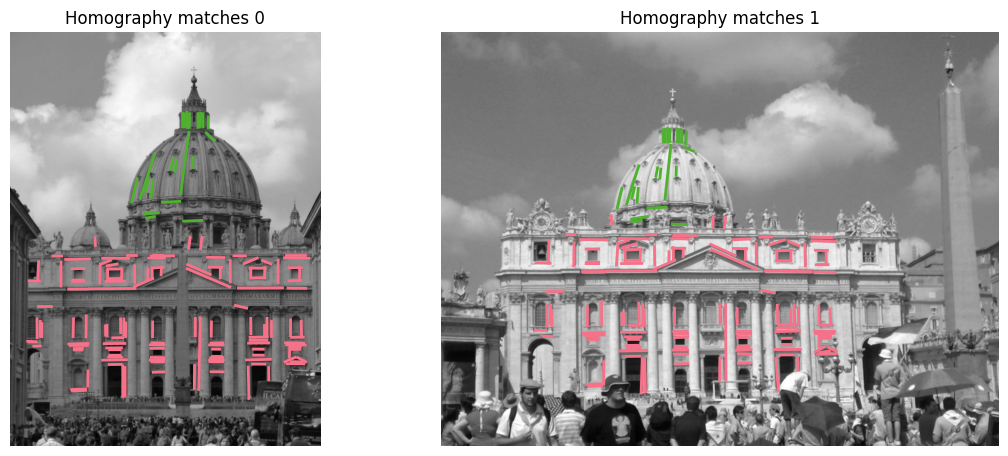

In [6]:
if True:
    m_lines0_sg_inl = m_lines0_sg[:, :, [1, 0]]
    m_lines1_sg_inl = m_lines1_sg[:, :, [1, 0]]

    homographies, labels = find_homography_points(m_lines0_sg[:, :, [1, 0]], m_lines1_sg[:, :, [1, 0]], img0.shape, img1.shape)
    plot_images([img0, img1], ['Homography matches 0', 'Homography matches 1'])
    
    n_homographies = max(labels)
    colors = sns.color_palette('husl', n_colors=n_homographies + 1)

    for label in range(n_homographies):
        inliers = [index for index, element in enumerate(labels) if element == label]
        plot_color_line_matches([m_lines0_sg_inl[inliers], m_lines1_sg_inl[inliers]], colors = [colors[label]] * len(inliers))